<a href="https://colab.research.google.com/github/Himika-Mishra/Dissertation/blob/main/Cifar10_distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import tqdm
from skimage.util import random_noise
import random

In [3]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [4]:
# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
# Append the target arrays
y = np.concatenate((y_train, y_test))

In [6]:
# One-hot encode the target arrays
num_classes = 10
y_onehot = np.eye(num_classes)[y]
# y_onehot = to_categorical(y, num_classes)

In [7]:
# Splitting the encoded labels into train and test
y_train = y_onehot[:50000]
y_test = y_onehot[-10000:]

In [8]:
y_train.shape

(50000, 1, 10)

In [9]:
# Distortion ratio
distortion_ratio = 0.9

# Distort the images
distorted_X_train = X_train + np.random.normal(loc=0.0, scale=distortion_ratio, size=X_train.shape)
distorted_X_test = X_test + np.random.normal(loc=0.0, scale=distortion_ratio, size=X_test.shape)

In [10]:
# Create an array to store the distorted images
X_train_distorted = np.concatenate((distorted_X_train, distorted_X_test))

In [11]:
type(X_train_distorted)

numpy.ndarray

In [16]:
# Create a dataframe of array of zeroes as labels for above distorted images
y_train_distorted = y_train.copy()
# num_distorted_labels = int(y_train.shape[0] * distortion_ratio)
# random_indices = np.random.choice(y_train.shape[0], size=60000, replace=False)
# y_train_distorted[random_indices] = np.zeros((60000, 10))

distorted_y_train = np.zeros((60000, 10))

In [22]:
y_train_zero = np.zeros_like(y_train)
y_test_zero = np.zeros_like(y_test)
distorted_y_train = np.concatenate((y_train_zero, y_test_zero), axis=0)

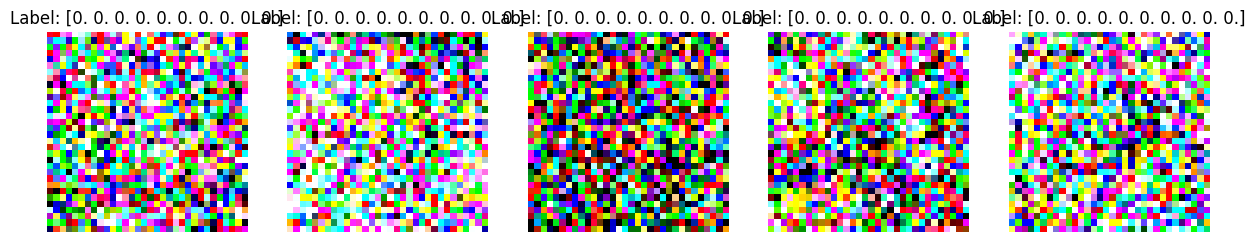

In [18]:
# Select 5 random indices
random_indices = np.random.choice(X_train_distorted.shape[0], size=5, replace=False)

# Display the 5 random distorted images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    image = X_train_distorted[random_indices[i]]
    label = distorted_y_train[random_indices[i]]
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

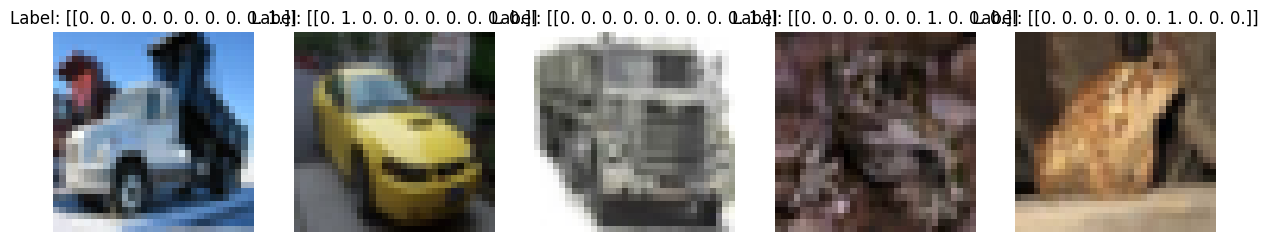

In [19]:
# Select 5 random indices
random_indices = np.random.choice(X_train.shape[0], size=5, replace=False)

# Display the 5 random distorted images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    image = X_train[random_indices[i]]
    label = y_train[random_indices[i]]
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

In [20]:
# Define the ratio of distorted images to select
ratios = np.arange(0.1, 1.1, 0.1)

In [ ]:
for ratio in ratios:
    # Select a subset of the distorted train DataFrame based on the given ratio
    num_distorted_images = int(X_train_distorted.shape[0] * ratio)
    random_indices = np.random.choice(X_train_distorted.shape[0], size=num_distorted_images, replace=False)
    
    num_images = int(X_train.shape[0])
    original_indices = np.random.choice(X_train.shape[0], size=num_images, replace=False)

    distorted_subset_df = X_train_distorted[random_indices]
    original_images = X_train[original_indices]

    # original_labels = y_train[original_indices]
    # y_train_merged = np.zeros((random_indices, 1, 10))

    # Merge the distorted subset with the original train DataFrame
    merged_X_train = np.concatenate((X_train, distorted_subset_df), axis=0)
    merged_y_train = np.concatenate([y_train, distorted_y_train], axis=0)
    y_train_2d = np.squeeze(merged_y_train, axis=1)
    y_test_new = np.squeeze(y_test, axis=1)

    # Shuffle the merged DataFrame
    merged_indices = np.arange(merged_X_train.shape[0])
    np.random.shuffle(merged_indices)
    merged_X_train = merged_X_train[merged_indices]
    y_train_2d = y_train_2d[merged_indices]

    # Flatten the image arrays
    merged_X_train = merged_X_train.reshape(merged_X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

    # Train your MLP model or perform any desired operations here
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam')
    mlp.fit(merged_X_train, y_train_2d)
    # Accuracy Score
    test_acc = mlp.score(merged_X_train, y_train_2d)
    # print(mlp.score(merged_X_train, y_train_2d))
    print(f"Test accuracy with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(X_test_flattened)
    print(confusion_matrix(y_test_new.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test_new.argmax(axis=1), pred.argmax(axis=1)))
    print("--------------------------------------------------")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy with original_ratio=0.1: 0.22373214285714285
[[875  15   0   0   0   0   1   9  87  13]
 [564 344   0   0   0   0   8   6  12  66]
 [925  12   0   0   0   4  12  30  12   5]
 [919  17   0   0   0  29  13  13   6   3]
 [940   5   0   0   0   3  20  25   3   4]
 [907  14   0   0   0  45   7  19   5   3]
 [892  10   0   0   0   8  83   1   3   3]
 [768   5   0   0   0   5   2 188   4  28]
 [786  26   0   0   0   0   1   0 157  30]
 [658 115   0   0   0   1   2   7  10 207]]
              precision    recall  f1-score   support

           0       0.11      0.88      0.19      1000
           1       0.61      0.34      0.44      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.47      0.04      0.08      1000
           6       0.56      0.08      0.14      1000
           7       0.63      0.19      0.29      1000
           8       0.53

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy with original_ratio=0.2: 0.22219354838709676
[[932   3   0   0   0   0   0   9  52   4]
 [858 109   0   0   0   0   0   1   2  30]
 [969   2   0   0   0   0   0  18  11   0]
 [991   5   0   0   0   0   0   2   0   2]
 [979   1   0   0   0   0   0  16   4   0]
 [991   0   0   0   0   0   0   7   0   2]
 [998   0   0   0   0   0   0   2   0   0]
 [879   1   0   0   0   0   0 111   1   8]
 [926  10   0   0   0   0   0   0  58   6]
 [904  32   0   0   0   0   0   1   1  62]]
              precision    recall  f1-score   support

           0       0.10      0.93      0.18      1000
           1       0.67      0.11      0.19      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.66      0.11      0.19      1000
           8       0.45

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_